<a href="https://colab.research.google.com/github/anggito-m/498140-Anggito-Muhammad-Amien-ResponsiJuniorProject/blob/master/Copy_of_CompVis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper dari https://ieeexplore.ieee.org/document/10928140

In [ ]:
!pip install swtloc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import shutil
from skimage import io, color, img_as_ubyte
import skimage as ski
import cv2
import matplotlib.pyplot as plt
import random
# import swtloc as swt
from skimage.feature import hog
from skimage.morphology import skeletonize
from skimage.measure import regionprops, label
import skimage.io as io # Import io from skimage
import numpy as np
import time

In [ ]:
# cara copy gdrive ke runtime
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Define paths
# Path asli gambar sebelum augmentasi
imgpath = '/content/drive/MyDrive/Dataset/COMPVIS/Datasets/datasets'
# Label asli gambar sebelum augmentasi
lblpath = '/content/drive/MyDrive/Dataset/COMPVIS/Datasets/attention.csv'
# Path Gambar hasil augmentasi
respath = '/content/drive/MyDrive/Dataset/COMPVIS/destination/dataset'
# Path Label hasil augmentasi
csv_path = '/content/drive/MyDrive/Dataset/COMPVIS/destination/labels_augmented.csv'

# Data Exploration

In [ ]:
# eksploarasi label
# no column head
df = pd.read_csv(lblpath, header=None)
df.head()

,0,1
0,1.png,1
1,2.png,2
2,3.png,1
3,4.png,4
4,5.png,1


In [ ]:
# ubah nama head column
df.columns = ['filename', 'label']
df.head()

,filename,label
0,1.png,1
1,2.png,2
2,3.png,1
3,4.png,4
4,5.png,1


In [ ]:
# hitung sebaran tiap label
df['label'].value_counts()

,count
label,
4,113
1,56
2,55
3,47
0,29


# Augmentasi Dataset

In [ ]:
# --- Load label dari CSV ---
df_labels = pd.read_csv(lblpath, header=None)  # Asumsikan format: filename,label
label_dict = dict(zip(df_labels[0], df_labels[1]))  # Mapping filename -> label

# --- Konfigurasi augmentasi ---
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.5, 1.5)
)

# --- Proses augmentasi ---
labels_data = []

for filename in os.listdir(imgpath):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        label = label_dict.get(filename, None)
        if label is None:
            print(f"[WARNING] Label untuk {filename} tidak ditemukan. Lewati.")
            continue

        # Path ke file asli dan tujuan salinan
        src_filepath = os.path.join(imgpath, filename)
        dst_filepath = os.path.join(respath, filename)

        # Salin file asli ke respath
        shutil.copy(src_filepath, dst_filepath)

        # Load gambar asli untuk augmentasi
        img = load_img(src_filepath)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Simpan info gambar asli ke data label
        labels_data.append({
            'filename': filename,
            'augmented_filename': filename,
            'label': label,
            'is_augmented': False
        })

        # Catat file sebelum augmentasi
        before_files = set(os.listdir(respath))

        # Augment dan simpan ke disk
        for i, batch in enumerate(datagen.flow(
            x,
            batch_size=1,
            save_to_dir=respath,
            save_prefix=os.path.splitext(filename)[0] + "_aug",
            save_format='jpeg'
        )):
            time.sleep(0.1)  # Jika file system lambat

            after_files = set(os.listdir(respath))
            new_files = after_files - before_files
            if new_files:
                aug_filename = new_files.pop()
                labels_data.append({
                    'filename': filename,
                    'augmented_filename': aug_filename,
                    'label': label,
                    'is_augmented': True
                })
                before_files = after_files

            if i >= 4:  # Total 5 augmentasi
                break


# --- Simpan Dataframe ke CSV ---
labels_df = pd.DataFrame(labels_data)
labels_df.to_csv(csv_path, index=False)

print(f"✅ Augmentasi selesai! CSV disimpan di: {csv_path}")
print("📊 Statistik label:")
print(labels_df['label'].value_counts())

✅ Augmentasi selesai! CSV disimpan di: /content/drive/MyDrive/Dataset/COMPVIS/destination/labels_augmented.csv
📊 Statistik label:
label
4    678
1    336
2    330
3    282
0    174
Name: count, dtype: int64


In [ ]:
len(labels_df)

1800

In [ ]:
import shutil

# Delete the 'grey image' folder if it exists
try:
    shutil.rmtree('/content/grey image')
    print("'grey image' folder deleted successfully.")
except FileNotFoundError:
    print("'grey image' folder not found.")
except Exception as e:
    print(f"Error deleting 'grey image' folder: {e}")


'grey image' folder not found.


# Preprocessing

greyscale,thresholding (pure B/W), Normalisasi Pixel Value, Resize, Centering and Padding untuk menjaga aspek rasio, edge detection, canny edge detection

In [ ]:
import os
import cv2
import numpy as np
from skimage import io, img_as_ubyte

# Path input & output
grey_image_folder = '/content/grey image'
os.makedirs(grey_image_folder, exist_ok=True)
# Check if CUDA is available
if cv2.cuda.getCudaEnabledDeviceCount() > 0:
    print("CUDA is available. Using GPU for processing.")
    use_cuda = True
else:
    print("CUDA is not available. Falling back to CPU.")
    use_cuda = False

# List menyimpan gambar yang telah dinormalisasi (optional)
normalized_images = []

# Loop seluruh gambar dalam folder
for filename in os.listdir(imgpath):
    # Skip hidden files like .DS_Store
    if filename.startswith('.'):
        continue

    filepath = os.path.join(imgpath, filename)

    # Baca gambar dalam format warna BGR
    bgr_image = cv2.imread(filepath)

    # Check if image loading was successful
    if bgr_image is None:
        print(f"Failed to load image: {filepath}")
        continue  # Skip to the next image

    # Konversi ke ruang warna LAB
    lab = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2LAB)


    # Pisahkan channel LAB
    l, a, b = cv2.split(lab)

    # CLAHE hanya pada channel L (intensitas/cahaya)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Gabungkan kembali dengan channel a dan b (warna)
    limg = cv2.merge((cl, a, b))

    # Konversi kembali ke RGB
    enhanced_rgb = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # -----------------------------
    # Background Removal with GrabCut
    # -----------------------------
    mask = np.zeros(enhanced_rgb.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    height, width = enhanced_rgb.shape[:2]
    rect = (10, 10, width - 20, height - 20)  # rectangle di dalam gambar

    try:
        cv2.grabCut(enhanced_rgb, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
        # 0 dan 2 -> background, 1 dan 3 -> foreground
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        result = enhanced_rgb * mask2[:, :, np.newaxis]
    except:
        # Jika GrabCut gagal, gunakan gambar asli
        result = enhanced_rgb

    # -----------------------------
    # Denoising dengan Non-Local Means
    # -----------------------------
    denoised = cv2.fastNlMeansDenoisingColored(result, None, 10, 10, 7, 21)

    # Bilateral Filter (menghaluskan tanpa hilangkan edge)
    filtered = cv2.bilateralFilter(denoised, d=9, sigmaColor=75, sigmaSpace=75)

    # Resize ke 224x224
    resized = cv2.resize(filtered, (224, 224))

    # Normalisasi ke 0–1 untuk training
    normalized = resized.astype('float32') / 255.0
    normalized_images.append(normalized)

    # Simpan dalam bentuk uint8 (0–255) untuk penyimpanan/visualisasi
    processed_image = img_as_ubyte(resized)

    # Buat path file simpan
    if 'aug' in filename:
        save_filename = os.path.splitext(filename)[0] + ".jpeg"
    else:
        save_filename = os.path.splitext(filename)[0] + ".png"

    save_path = os.path.join(grey_image_folder, save_filename)
    io.imsave(save_path, processed_image)


CUDA is not available. Falling back to CPU.


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/grey image/3.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/grey image/1.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/grey image/2.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/grey image/96.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/grey image/194.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/grey image/137.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/

In [ ]:
# colab zip and download
!zip -r "/content/grey image.zip" "/content/grey image"
from google.colab import files
files.download("/content/grey image.zip")

  adding: content/grey image/ (stored 0%)
  adding: content/grey image/39_aug_0_7315.jpeg (deflated 2%)
  adding: content/grey image/176_aug_0_6393.jpeg (deflated 9%)
  adding: content/grey image/287_aug_0_9358.jpeg (deflated 7%)
  adding: content/grey image/17_aug_0_3666.jpeg (deflated 5%)
  adding: content/grey image/77_aug_0_1845.jpeg (deflated 3%)
  adding: content/grey image/175_aug_0_6417.jpeg (deflated 4%)
  adding: content/grey image/98_aug_0_9506.jpeg (deflated 7%)
  adding: content/grey image/234_aug_0_2265.jpeg (deflated 3%)
  adding: content/grey image/236_aug_0_7301.jpeg (deflated 4%)
  adding: content/grey image/254_aug_0_3938.jpeg (deflated 8%)
  adding: content/grey image/167_aug_0_940.jpeg (deflated 8%)
  adding: content/grey image/60_aug_0_7007.jpeg (deflated 5%)
  adding: content/grey image/279_aug_0_9168.jpeg (deflated 27%)
  adding: content/grey image/245_aug_0_8833.jpeg (deflated 4%)
  adding: content/grey image/9.png (deflated 1%)
  adding: content/grey image/199

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# hitung jumlah gambar dalam grey_image
len(os.listdir(grey_image_folder))

1800

In [ ]:
len(os.listdir(respath))

1800

## Show 10 random image

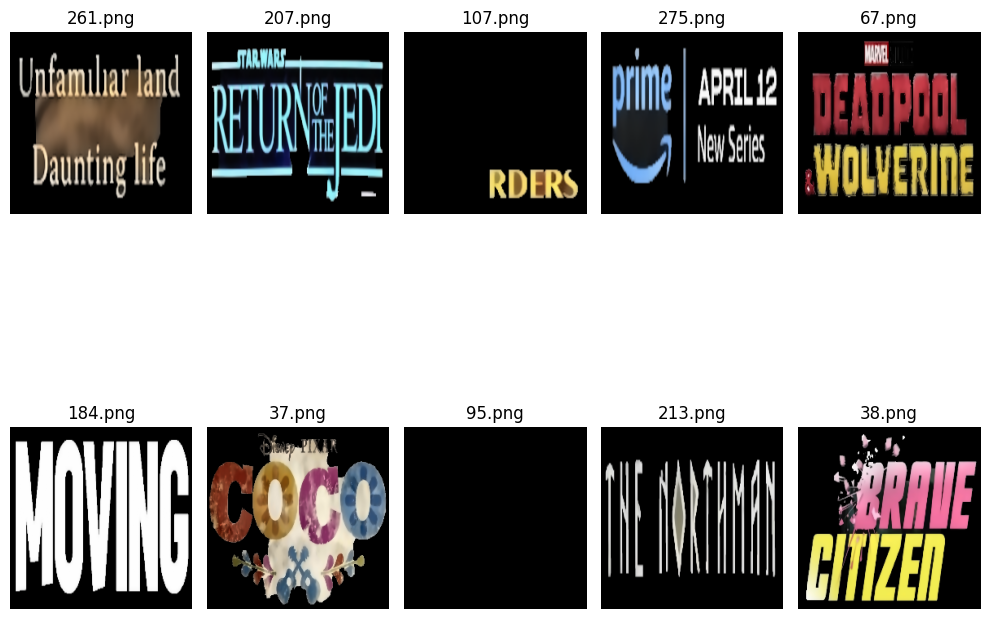

In [ ]:
# show 10 image from grey_image_folder


# Get a list of all image files in the folder
image_files = [f for f in os.listdir(grey_image_folder) if os.path.isfile(os.path.join(grey_image_folder, f))]

# Select 10 random images
selected_images = random.sample(image_files, 10)

# Display the selected images
plt.figure(figsize=(10, 10))  # Adjust figure size as needed
for i, image_file in enumerate(selected_images):
    image_path = os.path.join(grey_image_folder, image_file)
    image = plt.imread(image_path)
    plt.subplot(2, 5, i + 1)  # Arrange images in a 2x5 grid
    plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.title(image_file)  # Set the title to the filename
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the plot

# Feature Extraction

## Stroke Width Transform

In [ ]:
# Define the path for the 'grey_image' folder
swt_image_folder = '/content/swt image'

# Create the folder if it doesn't exist
os.makedirs(swt_image_folder, exist_ok=True)


# Initializing the SWTLocalizer class with the image path
for filename in os.listdir(grey_image_folder):
  image_path = os.path.join(grey_image_folder, filename)

  swtl = swt.SWTLocalizer(image_paths=image_path)  # Pass the full path
  # # Accessing the SWTImage Object which is housing this image
  # swtImgObj = swtl.swtimages[0]
  # # Performing Stroke Width Transformation
  # swt_mat = swtImgObj.transformImage(text_mode='db_lf')
  #   # Construct the full file path for the grey image in the 'grey_image' folder
      # HOG
  # Load the image data using io.imread
  image = io.imread(image_path)
  hog_features, _ = hog(image.squeeze(), pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

  # Skeletonization
  skeleton = skeletonize(image.squeeze() > 0).astype(np.uint8)

  # Geometric Properties
  labeled = label(image.squeeze())
  props = regionprops(labeled)
  geometry = [prop.area for prop in props]
  # add dataframe with this extraction result and its name of image


KeyboardInterrupt: 

In [ ]:
# add

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0, 131,   0],
       [  0,   0,   0, ...,   0, 133,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

# Create Model CNN

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
# def load_dataset(dataset_dir):
#     images = []
#     labels = []
#     class_names = os.listdir(dataset_dir)

#     for label in class_names:
#         class_path = os.path.join(dataset_dir, label)
#         for img_file in os.listdir(class_path):
#             img = preprocess_image(os.path.join(class_path, img_file))
#             images.append(img)
#             labels.append(label)

#     return np.array(images), np.array(labels)


In [ ]:
# dataset_dir = '/content/grey image'
# images = []
# filenames = [] # To store filenames for mapping with labels

# for filename in os.listdir(respath):
#     if filename.endswith(('.jpg', '.jpeg', '.png')):
#         image_path = os.path.join(dataset_dir, filename)
#         images.append(image_path)
#         filenames.append(filename)

# X = np.array(images)



In [ ]:
# # --- Load Labels ---
# y_df = pd.read_csv("/content/drive/MyDrive/Dataset/COMPVIS/destination/labels_augmented.csv")
# # Create a dictionary to map filenames to labels
# filename_to_label = dict(zip(y_df['augmented_filename'], y_df['label']))
# # Get labels for the images in X based on filenames
# y = np.array([filename_to_label.get(filename) for filename in filenames])


In [ ]:
y

array([2, 2, 2, ..., 1, 2, 2])

In [ ]:
# import pandas as pd
# import os

# # --- Load Dataset ---
# dataset_dir = '/content/grey image'
# filenames = []  # To store filenames

# for filename in os.listdir(dataset_dir):
#     if filename.endswith(('.jpg', '.jpeg', '.png')):
#         filenames.append(filename)

# # --- Load Labels ---
# y_df = pd.read_csv("/content/drive/MyDrive/Dataset/COMPVIS/destination/labels_augmented.csv")

# # Create a dictionary to map filenames to labels
# filename_to_label = dict(zip(y_df['augmented_filename'], y_df['label']))

# # Find files with missing labels
# missing_labels_files = []
# for filename in filenames:
#     if filename_to_label.get(filename) is None:
#         missing_labels_files.append(filename)

# # Print the files with missing labels
# print("Files with missing labels:")
# for file in missing_labels_files:
#     print(file)

Files with missing labels:


In [ ]:
# # set label untuk label file yang hilang
# for filename in missing_labels_files:
#     if filename_to_label.get(filename) is None:
#         filename_to_label[filename] = 3  # Set default label to -1
#         print(f"Setting label 3 for {filename}")  # Optional: Print a message


In [ ]:
# # hitung jumlah data di X
# len(X)

1800

In [ ]:
# # --- Prepare Dataset ---
# # Get labels as a list from the dictionary
# y = [filename_to_label.get(filename) for filename in filenames]
# # Now y is a list of labels, which can be used for stratification
# y

[0,
 3,
 1,
 3,
 4,
 0,
 4,
 2,
 2,
 4,
 3,
 2,
 2,
 4,
 0,
 0,
 3,
 3,
 4,
 1,
 3,
 1,
 4,
 0,
 4,
 2,
 1,
 2,
 3,
 4,
 4,
 4,
 1,
 0,
 4,
 4,
 1,
 4,
 4,
 0,
 4,
 2,
 4,
 0,
 4,
 1,
 3,
 1,
 4,
 4,
 0,
 1,
 4,
 4,
 2,
 4,
 3,
 0,
 2,
 0,
 3,
 4,
 3,
 0,
 2,
 3,
 4,
 2,
 2,
 1,
 4,
 3,
 2,
 0,
 4,
 1,
 3,
 4,
 0,
 3,
 2,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 4,
 0,
 1,
 0,
 4,
 1,
 4,
 0,
 3,
 1,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 2,
 3,
 3,
 4,
 0,
 4,
 4,
 3,
 0,
 4,
 4,
 1,
 4,
 1,
 4,
 4,
 1,
 1,
 2,
 4,
 4,
 4,
 4,
 3,
 1,
 2,
 4,
 1,
 1,
 3,
 3,
 1,
 3,
 2,
 1,
 2,
 4,
 2,
 3,
 3,
 4,
 4,
 4,
 4,
 3,
 0,
 2,
 4,
 3,
 2,
 3,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 0,
 4,
 4,
 2,
 0,
 1,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 4,
 4,
 4,
 1,
 4,
 4,
 1,
 2,
 1,
 3,
 4,
 1,
 2,
 3,
 1,
 0,
 3,
 2,
 0,
 4,
 2,
 3,
 4,
 2,
 4,
 2,
 1,
 4,
 4,
 1,
 4,
 2,
 1,
 2,
 1,
 3,
 1,
 3,
 3,
 4,
 3,
 0,
 4,
 2,
 0,
 1,
 4,
 2,
 4,
 4,
 1,
 4,
 0,
 3,
 0,
 4,
 3,
 2,
 4,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 3,


In [ ]:
# unzip data grey_image
!unzip "/content/grey image.zip" -d "/content/grey image"

Archive:  /content/grey image.zip
   creating: /content/grey image/content/grey image/
  inflating: /content/grey image/content/grey image/39_aug_0_7315.jpeg  
  inflating: /content/grey image/content/grey image/176_aug_0_6393.jpeg  
  inflating: /content/grey image/content/grey image/287_aug_0_9358.jpeg  
  inflating: /content/grey image/content/grey image/17_aug_0_3666.jpeg  
  inflating: /content/grey image/content/grey image/77_aug_0_1845.jpeg  
  inflating: /content/grey image/content/grey image/175_aug_0_6417.jpeg  
  inflating: /content/grey image/content/grey image/98_aug_0_9506.jpeg  
  inflating: /content/grey image/content/grey image/234_aug_0_2265.jpeg  
  inflating: /content/grey image/content/grey image/236_aug_0_7301.jpeg  
  inflating: /content/grey image/content/grey image/254_aug_0_3938.jpeg  
  inflating: /content/grey image/content/grey image/167_aug_0_940.jpeg  
  inflating: /content/grey image/content/grey image/60_aug_0_7007.jpeg  
  inflating: /content/grey imag

In [ ]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# --- Load Images and Labels ---
# dataset_dir = '/content/grey image'
dataset_dir ='/content/grey image'
images = []
labels = []
filenames = []  # To store filenames for mapping with labels

for filename in os.listdir(dataset_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(dataset_dir, filename)
        # Load the actual image data
        img = load_img(image_path, target_size=(224, 224))  # Load and resize
        img_array = img_to_array(img)

        images.append(img_array)
        filenames.append(filename)

X = np.array(images)

# --- Load Labels ---
y_df = pd.read_csv("/content/drive/MyDrive/Dataset/COMPVIS/destination/labels_augmented.csv")
# Create a dictionary to map filenames to labels
filename_to_label = dict(zip(y_df['augmented_filename'], y_df['label']))

# --- Ensure all images have labels ---
# If a filename is not found in filename_to_label, assign a default label (e.g., -1)
labels = [filename_to_label.get(filename, -1) for filename in filenames]
y = np.array(labels)

# --- Filter out images with missing labels if necessary ---
# If you want to exclude images with missing labels:
valid_indices = [i for i, label in enumerate(labels) if label != -1]
X = X[valid_indices]
y = y[valid_indices]

# --- Prepare Dataset ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ... (rest of your code) ...

In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight



In [ ]:
# # --- Prepare Dataset ---
# # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # --- CNN Model with Transfer Learning ---
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)           # Normalisasi untuk stabilkan training
# x = Dropout(0.5)(x)                   # Regularisasi untuk hindari overfitting
# output = Dense(len(np.unique(y)), activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=output)

# for layer in base_model.layers:
#     if 'block5a' in layer.name:  # Mulai unfreeze dari block tertentu
#         layer.trainable = True

# # Recompile model dengan learning rate lebih rendah untuk fine-tuning
# model.compile(optimizer=Adam(1e-6),  # Learning rate lebih kecil
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # --- Data Augmentation ---
# # datagen = ImageDataGenerator(
# #     rotation_range=20,
# #     width_shift_range=0.1,
# #     height_shift_range=0.1,
# #     zoom_range=0.2,
# #     horizontal_flip=True
# # )

# # Convert grayscale to 3 channels if it's not already
# if X_train.shape[-1] != 3:  # Check if the last dimension (channels) is not 3
#     X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1) # add new axis for single channel data
#     X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1) # add new axis for single channel data
# else:
#     X_train_rgb = X_train
#     X_val_rgb = X_val

# # Train without datagen
# history = model.fit(
#     X_train_rgb, y_train,
#     validation_data=(X_val_rgb, y_val),
#     epochs=30
# )

# # history = model.fit(
# #     datagen.flow(X_train_rgb, y_train, batch_size=32),
# #     validation_data=(X_val_rgb, y_val),
# #     epochs=30
# # )

# # --- Plot Accuracy & Loss ---
# plt.plot(history.history['accuracy'], label='Train Acc')
# plt.plot(history.history['val_accuracy'], label='Val Acc')
# plt.legend()
# plt.title("Accuracy")
# plt.show()

# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title("Loss")
# plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.1821 - loss: 11.2564 - val_accuracy: 0.1833 - val_loss: 54.4318 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2366 - loss: 10.3391 - val_accuracy: 0.1000 - val_loss: 629619.7500 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1947 - loss: 10.4197 - val_accuracy: 0.1000 - val_loss: 890376.2500 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2126 - loss: 9.5657 - val_accuracy: 0.4000 - val_loss: 113730.2969 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2709 - loss: 9.0381 - val_accuracy: 0.3833 - val_loss: 412236.1875 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2531 - loss: 8.7860 - val_accuracy: 0.1500 - val_loss: 349656.6875 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2256 - loss: 8.4978 

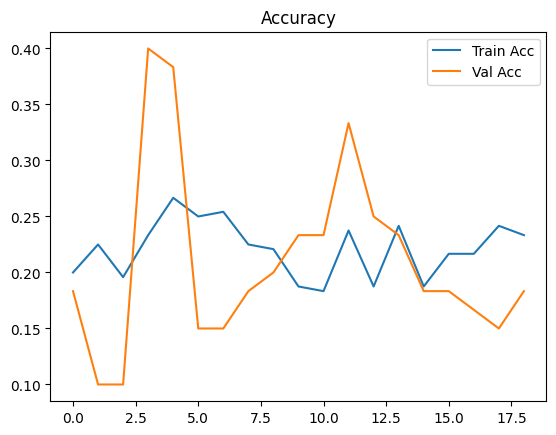

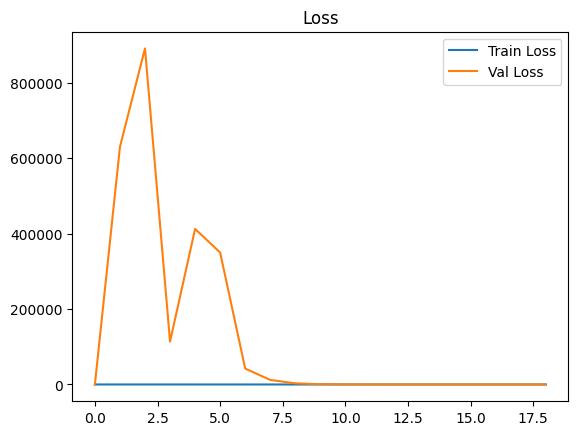

In [ ]:
# --- Prepare Dataset ---
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- CNN Model with Transfer Learning ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)           # Normalisasi untuk stabilkan training
x = Dropout(0.6)(x)                   # Regularisasi untuk hindari overfitting
output = Dense(len(np.unique(y)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    if 'block5a' in layer.name:  # Mulai unfreeze dari block tertentu
        layer.trainable = True

# Recompile model dengan learning rate lebih rendah untuk fine-tuning
model.compile(optimizer="Adam",  # Learning rate lebih kecil
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric yang dipantau
    patience=15,         # Jumlah epoch tunggu sebelum berhenti
    restore_best_weights=True  # Kembalikan bobot terbaik
)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Nama file penyimpanan
    monitor='val_accuracy',    # Metric yang dipantau
    save_best_only=True,      # Hanya simpan yang terbaik
    mode='max'                # Mode 'max' untuk accuracy, 'min' untuk loss
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric yang dipantau
    factor=0.2,         # Faktor pengurangan (new_lr = lr * factor)
    patience=5,         # Jumlah epoch tunggu sebelum mengurangi LR
    min_lr=1e-7         # Learning rate minimum
)
tensorboard = TensorBoard(
    log_dir='./logs',  # Direktori penyimpanan log
    histogram_freq=1   # Frekuensi update histogram
)
callbacks_list = [
    early_stopping,
    checkpoint,
    reduce_lr,
    tensorboard  # Aktifkan jika diperlukan
]

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Convert grayscale to 3 channels if it's not already
if X_train.shape[-1] != 3:  # Check if the last dimension (channels) is not 3
    X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1) # add new axis for single channel data
    X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1) # add new axis for single channel data
else:
    X_train_rgb = X_train
    X_val_rgb = X_val

# Train
history = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32), # Use datagen.flow
    validation_data=(X_val_rgb, y_val),
    epochs=50,
    callbacks=callbacks_list,
    class_weight=class_weights
)

# --- Plot Accuracy & Loss ---
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
# del model, base_model, history, X_train_rgb, X_val_rgb

### Fine Tune

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [ ]:
# Optional warm-up scheduler
def warmup_scheduler(epoch, lr):
    return lr * 1.1 if epoch < 5 else lr
warmup = LearningRateScheduler(warmup_scheduler)

callbacks_list = [early_stopping, checkpoint, reduce_lr, tensorboard, warmup]

In [ ]:
# --- Fine-Tuning: Unfreeze some deeper layers ---
for layer in base_model.layers:
    if layer.name.startswith('conv5_block') or layer.name.startswith('conv4_block'):
        layer.trainable = True

# Recompile with lower LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Fine-Tuning Training ---
history_finetune = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    callbacks=callbacks_list,
    class_weight=class_weights
)

# --- Combine History for Plotting ---
def plot_history(histories, metric):
    plt.figure()
    for h in histories:
        plt.plot(h.history[metric])
    for h in histories:
        plt.plot(h.history['val_' + metric])
    plt.title(metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(['Train (init)', 'Train (finetune)', 'Val (init)', 'Val (finetune)'])
    plt.show()



Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.2351 - loss: 8.9769 - val_accuracy: 0.3833 - val_loss: 10139.3691 - learning_rate: 1.1000e-05
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2616 - loss: 8.9665 - val_accuracy: 0.3833 - val_loss: 2118.1819 - learning_rate: 1.2100e-05
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1907 - loss: 9.1855 - val_accuracy: 0.3667 - val_loss: 608.5991 - learning_rate: 1.3310e-05
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2655 - loss: 9.2494 - val_accuracy: 0.3667 - val_loss: 251.2233 - learning_rate: 1.4641e-05
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1958 - loss: 9.1562 - val_accuracy: 0.3667 - val_loss: 111.8073 - learning_rate: 1.6105e-05
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2115 - loss: 9.1677 - val_accuracy: 0.3333 - val_loss: 54.4246 - learning_rate: 1.6105e-05
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2447 - loss:

NameError: name 'history_initial' is not defined

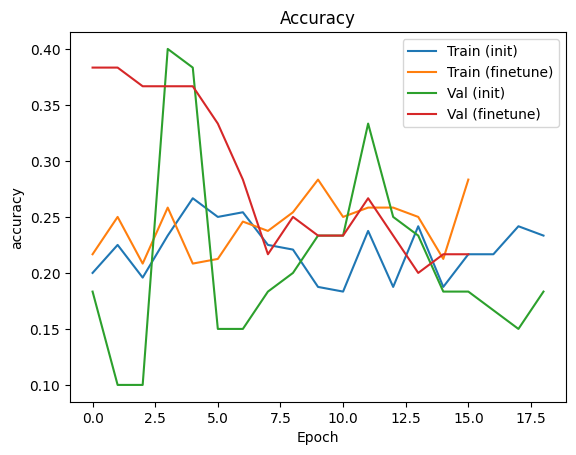

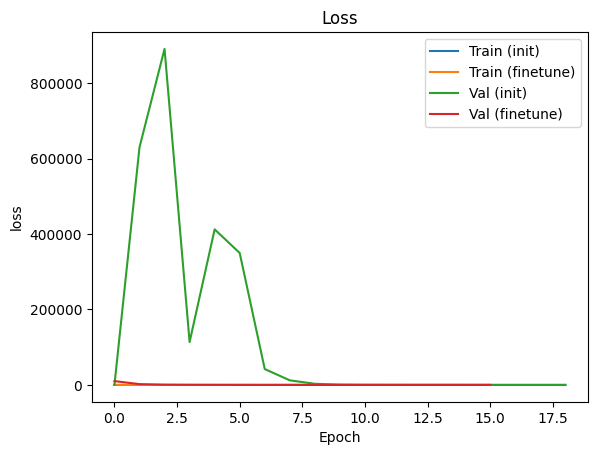

In [ ]:
plot_history([history, history_finetune], 'accuracy')
plot_history([history, history_finetune], 'loss')


## Confussion Matrix

In [ ]:
# load model
from tensorflow.keras.models import load_model
model = load_model('/content/best_model.keras')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi kelas pada data validasi
y_pred = model.predict(X_val_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi probabilitas ke kelas

# Jika y_val belum dalam bentuk integer (one-hot encoded)
y_true = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step


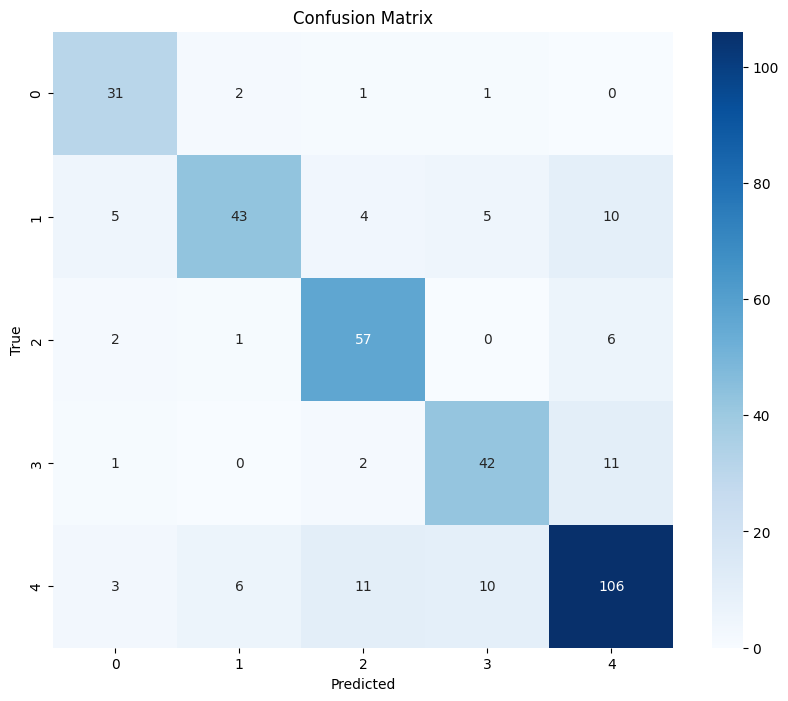

In [ ]:
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load model dari file .keras
model = load_model("/content/best_model.keras")

# Tampilkan ringkasan arsitektur
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,618,449 (90.10 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 20,492 (80.05 KB)

# Implementasi: LBP (Local Binary Pattern) + ResNet50

## Ekstrak Fitur LBP

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import cv2

In [ ]:
def extract_lbp_features(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 27),  # 26 LBP types + 1
                             range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize
    return hist

## Ekstrak fitur dari CNN

In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')
def extract_cnn_features(img_path):
    # Use the correct image module for loading
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet.predict(x)
    return features.flatten()

In [ ]:
X_combined = []
# Get a list of image files in respath
image_files = [os.path.join(respath, f) for f in os.listdir(respath) if os.path.isfile(os.path.join(respath, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Loop through the image files
for path in image_files:
    texture_feat = extract_lbp_features(path)
    cnn_feat = extract_cnn_features(path)
    combined_feat = np.concatenate([cnn_feat, texture_feat])
    X_combined.append(combined_feat)

X_combined = np.array(X_combined)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_combined, y)


RandomForestClassifier()

In [ ]:
#dapatkan info akurasi random forest sebelumnya
clf.score(X_combined, y)


1.0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_combined.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(units=5, activation='softmax') # Changed num_classes to units
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_combined, y, epochs=20, validation_split=0.2)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3093 - loss: 2.1206 - val_accuracy: 0.3806 - val_loss: 1.5621
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4798 - loss: 1.2580 - val_accuracy: 0.3750 - val_loss: 1.6281
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6068 - loss: 0.9853 - val_accuracy: 0.3222 - val_loss: 1.8195
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7033 - loss: 0.7295 - val_accuracy: 0.3778 - val_loss: 2.1735
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8066 - loss: 0.5310 - val_accuracy: 0.3056 - val_loss: 2.1701
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8645 - loss: 0.3744 - val_accuracy: 0.3611 - val_loss: 2.5570
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8869 - loss: 0.3013 - val_accuracy: 0.3167 - val_loss: 2.7361
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9245 - loss: 0.2105 - val_accuracy: 0.3556 - v

In [ ]:
from sklearn.model_selection import train_test_split # Import the missing function

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(np.unique(y)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Convert grayscale to 3 channels if it's not already
if X_train.shape[-1] != 3:  # Check if the last dimension (channels) is not 3
    X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, axis=-1) # add new axis for single channel data
    X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1) # add new axis for single channel data
else:
    X_train_rgb = X_train
    X_val_rgb = X_val

# Add a batch dimension to X_train_rgb and X_val_rgb for each sample
X_train_rgb = X_train_rgb[np.newaxis, ...]  # or X_train_rgb = np.expand_dims(X_train_rgb, axis=0)
X_val_rgb = X_val_rgb[np.newaxis, ...]  # or X_val_rgb = np.expand_dims(X_val_rgb, axis=0)

# Train the model
history = model.fit(
    datagen.flow(X_train_rgb[0], y_train, batch_size=32), # Access the data inside the extra dimension
    validation_data=(X_val_rgb[0], y_val), # Access the data inside the extra dimension
    epochs=10
)


# --- Plot Accuracy & Loss ---
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

ValueError: could not convert string to float: np.str_('/content/grey image/246_aug_0_4933.jpeg')

## 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow.keras.backend as K
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import os

# --- Hyperparameters ---
LBP_POINTS = 8
LBP_RADIUS = 1
LBP_BINS = 26  # 26 uniform patterns

# --- LBP Function ---
def compute_lbp_histogram(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_BINS + 1), range=(0, LBP_BINS))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# --- LBP Wrapper for Keras ---
def lbp_layer(x):
    def compute_lbp(img_batch):
        histograms = []
        for img in img_batch:
            img = img.astype(np.uint8)
            lbp_hist = compute_lbp_histogram(img)
            histograms.append(lbp_hist)
        return np.array(histograms).astype(np.float32)
    return tf.numpy_function(compute_lbp, [x], tf.float32)

# --- Model Construction ---
def build_cnn_lbp_model(input_shape=(224, 224, 3), num_classes=10):
    img_input = Input(shape=input_shape)

    # Pretrained CNN (frozen)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=img_input)
    base_model.trainable = False
    cnn_feat = GlobalAveragePooling2D()(base_model.output)

    # LBP texture branch
    # Specify the output shape for the Lambda layer
    lbp_feat = Lambda(lbp_layer, output_shape=(LBP_BINS,))(img_input)

    # Concatenate CNN + LBP
    combined = Concatenate()([cnn_feat, lbp_feat])

    # Dense classification head
    x = Dense(256, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=img_input, outputs=output)
    return model

In [ ]:
model = build_cnn_lbp_model(input_shape=(224, 224, 3), num_classes=len(np.unique(y)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Preprocessing
def preprocess(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)  # ResNet pre-processing
    return img

# Get a list of image files in respath
image_files = [os.path.join(respath, f) for f in os.listdir(respath) if os.path.isfile(os.path.join(respath, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Preprocess each image file
X_img = np.array([preprocess(p) for p in image_files])  # Use image_files instead of respath
y = np.array(y)

# Training
model.fit(X_img, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 366s 8s/step - accuracy: 0.3926 - loss: 1.8670 - val_accuracy: 0.3083 - val_loss: 1.8046
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 375s 8s/step - accuracy: 0.7300 - loss: 0.7481 - val_accuracy: 0.3667 - val_loss: 2.3257
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - accuracy: 0.8767 - loss: 0.4082 - val_accuracy: 0.3833 - val_loss: 2.4275
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.9309 - loss: 0.2594 - val_accuracy: 0.3722 - val_loss: 2.3628
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 337s 8s/step - accuracy: 0.9670 - loss: 0.1521 - val_accuracy: 0.3139 - val_loss: 2.5218
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 337s 8s/step - accuracy: 0.9816 - loss: 0.1079 - val_accuracy: 0.3806 - val_loss: 2.6619
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 394s 8s/step - accuracy: 0.9853 - loss: 0.0740 - val_accuracy: 0.3639 - val_loss: 2.7323
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 383s 8s/step - accuracy: 0.9922 - loss: 0.0620 - val_accuracy: 0.3361 - v